# **Head Pose Estemation**

In [91]:
'''
A robust and efficient system for 3D head pose estimation, utilizing machine learning techniques trained on the AFLW2000 dataset.
'''

'\nA robust and efficient system for 3D head pose estimation, utilizing machine learning techniques trained on the AFLW2000 dataset.\n'

In [2]:
# Install necessary libraries
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 22.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatib

In [82]:
# Import libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import io as sio
import mediapipe as mp
from math import cos, sin, radians
import pickle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from google.colab.patches import cv2_imshow
import warnings
warnings.filterwarnings('ignore')
from imutils.video import VideoStream
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import html
import time

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Configuration
DATASET_PATH = '/content/drive/MyDrive/AFLW2000'
face_mesh = mp.solutions.face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5
)

In [6]:
def draw_axis(img, pitch, yaw, roll, tdx=None, tdy=None, size=100):
    """Draw 3D coordinate axes on image"""
    yaw = -yaw
    if tdx is not None and tdy is not None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1), int(y1)), (0, 0, 255), 3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2), int(y2)), (0, 255, 0), 3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3), int(y3)), (255, 0, 0), 2)
    return img

In [7]:
def extract_landmarks(image_path):
    """Extract 468 facial landmarks from image using MediaPipe"""
    image = cv2.imread(image_path)
    if image is None:
        return None

    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if results.multi_face_landmarks:
        landmarks = []
        for face_landmarks in results.multi_face_landmarks:
            for landmark in face_landmarks.landmark:
                landmarks.extend([landmark.x, landmark.y, landmark.z])
        return np.array(landmarks)
    return None

In [8]:
def load_pose_angles(mat_file_path):
    """Load pitch, yaw, roll angles from .mat file"""
    try:
        mat_file = sio.loadmat(mat_file_path)
        pose_para = mat_file["Pose_Para"][0][:3]
        pitch, yaw, roll = pose_para[0], pose_para[1], pose_para[2]
        return pitch, yaw, roll
    except:
        return None, None, None


# 1. DATA LOADING AND PREPROCESSING


In [9]:
print("🔄 Starting Data Loading and Preprocessing...")

# Get all image files
image_files = [f for f in os.listdir(DATASET_PATH) if f.endswith('.jpg')]
print(f"Found {len(image_files)} images in dataset")

🔄 Starting Data Loading and Preprocessing...
Found 2000 images in dataset


In [10]:
# Initialize data storage
landmark_data = []
pose_data = []
valid_files = []

In [14]:
print("📊 Extracting landmarks and pose data...")
for i, img_file in enumerate(image_files):
    if i % 10 == 0:
        print(f"Processing image {i+1}/{len(image_files)}")

    base_name = img_file.replace('.jpg', '')
    img_path = os.path.join(DATASET_PATH, img_file)
    mat_path = os.path.join(DATASET_PATH, base_name + '.mat')

    # Extract landmarks
    landmarks = extract_landmarks(img_path)
    if landmarks is None:
        continue

    # Load pose angles
    pitch, yaw, roll = load_pose_angles(mat_path)
    if pitch is None:
        continue

    landmark_data.append(landmarks)
    pose_data.append([pitch, yaw, roll])
    valid_files.append(base_name)

# Convert to numpy arrays
X = np.array(landmark_data)  # Features: facial landmarks
y = np.array(pose_data)      # Targets: [pitch, yaw, roll]

📊 Extracting landmarks and pose data...
Processing image 1/2000
Processing image 11/2000
Processing image 21/2000
Processing image 31/2000
Processing image 41/2000
Processing image 51/2000
Processing image 61/2000
Processing image 71/2000
Processing image 81/2000
Processing image 91/2000
Processing image 101/2000
Processing image 111/2000
Processing image 121/2000
Processing image 131/2000
Processing image 141/2000
Processing image 151/2000
Processing image 161/2000
Processing image 171/2000
Processing image 181/2000
Processing image 191/2000
Processing image 201/2000
Processing image 211/2000
Processing image 221/2000
Processing image 231/2000
Processing image 241/2000
Processing image 251/2000
Processing image 261/2000
Processing image 271/2000
Processing image 281/2000
Processing image 291/2000
Processing image 301/2000
Processing image 311/2000
Processing image 321/2000
Processing image 331/2000
Processing image 341/2000
Processing image 351/2000
Processing image 361/2000
Processin

In [16]:
print(f"✅ Successfully processed {len(X)} images")
print(f"Feature shape: {X.shape}")
print(f"Target shape: {y.shape}")

✅ Successfully processed 1843 images
Feature shape: (1843, 1434)
Target shape: (1843, 3)


# 2. LANDMARK VISUALIZATION


🎨 Visualizing Landmarks...
Visualizing sample images with landmarks and pose axes:
Sample 0: Pitch=-0.16, Yaw=0.01, Roll=0.01


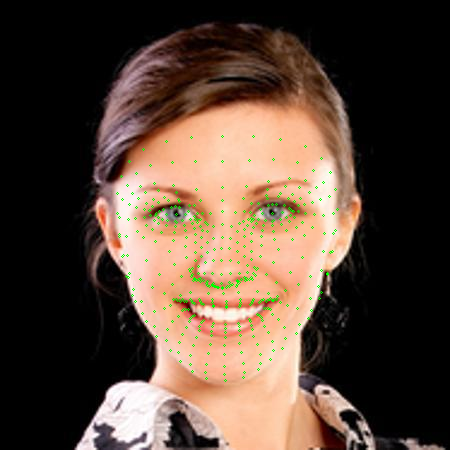

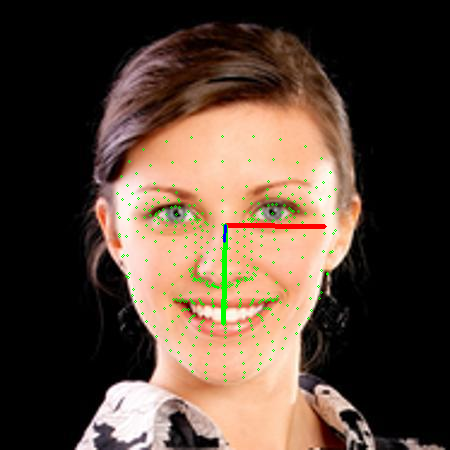

Sample 1: Pitch=0.03, Yaw=0.35, Roll=-0.06


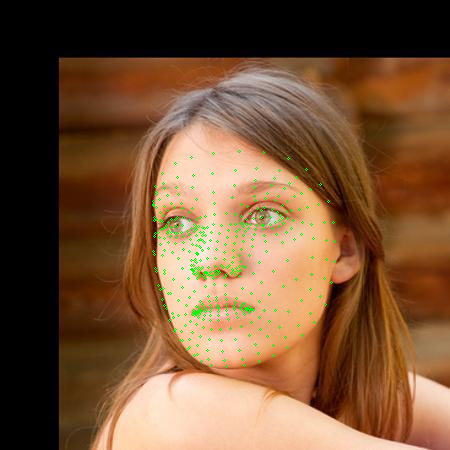

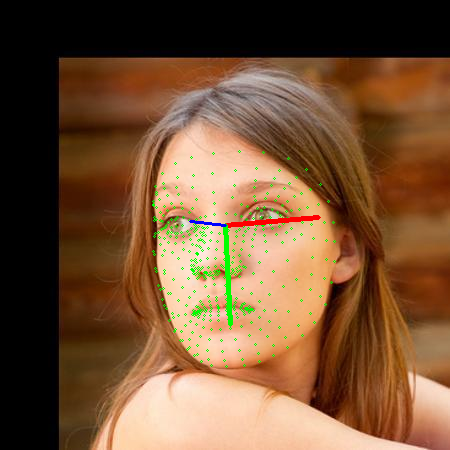

Sample 2: Pitch=0.00, Yaw=0.23, Roll=-0.08


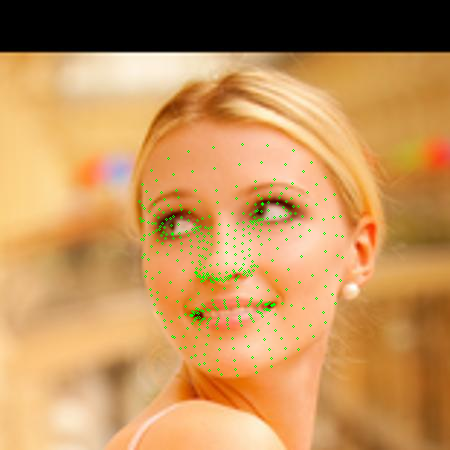

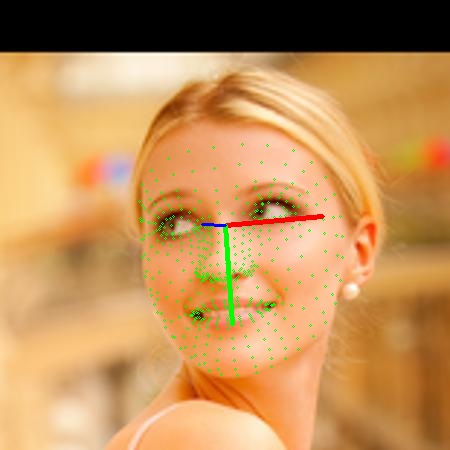

In [20]:
print("\n🎨 Visualizing Landmarks...")

def visualize_sample_with_landmarks(sample_idx=0):
    """Visualize a sample image with landmarks and pose axes"""
    base_name = valid_files[sample_idx]
    image = cv2.imread(os.path.join(DATASET_PATH, base_name + '.jpg'))

    # Check if image loaded successfully
    if image is None:
        print(f"Error: Could not load image {base_name}.jpg")
        return

    # Draw landmarks
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # Added check for results and landmarks before iterating
    if results and results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            for landmark in face_landmarks.landmark:
                h, w, _ = image.shape
                # Added boundary checks for coordinates
                x = int(landmark.x * w)
                y_coord = int(landmark.y * h) # Renamed y to avoid conflict with global y
                if 0 <= x < w and 0 <= y_coord < h:
                     cv2.circle(image, (x, y_coord), 1, (0, 255, 0), 1)


    # Draw pose axes
    # Ensure y is a numpy array here before subscripting
    if isinstance(y, np.ndarray) and y.shape[0] > sample_idx:
        pitch, yaw, roll = y[sample_idx]
        image_with_axes = draw_axis(image.copy(), pitch, yaw, roll)
    else:
        print(f"Error: 'y' is not in the expected format or sample_idx {sample_idx} is out of bounds.")
        image_with_axes = image.copy() # Just show original image if pose data is problematic


    print(f"Sample {sample_idx}: Pitch={pitch:.2f}, Yaw={yaw:.2f}, Roll={roll:.2f}")
    cv2_imshow(image)
    cv2_imshow(image_with_axes)

# Visualize a few samples
print("Visualizing sample images with landmarks and pose axes:")
for i in range(min(3, len(valid_files))):
    # Added a check to ensure the index is valid for y
    if i < len(y):
        visualize_sample_with_landmarks(i)
    else:
        print(f"Warning: Sample index {i} is out of bounds for pose data (y). Skipping.")

# 3. STATISTICAL ANALYSIS OF POSE DISTRIBUTIONS

In [21]:
print("\n📈 Statistical Analysis of Pose Distributions...")

# Create DataFrame for easier analysis
pose_df = pd.DataFrame(y, columns=['Pitch', 'Yaw', 'Roll'])


📈 Statistical Analysis of Pose Distributions...


In [22]:
# Basic statistics
print("📊 Pose Distribution Statistics:")
print(pose_df.describe())

📊 Pose Distribution Statistics:
             Pitch          Yaw         Roll
count  1843.000000  1843.000000  1843.000000
mean     -0.092840     0.009377    -0.034751
std       0.540313     0.572463     0.640056
min     -12.457202    -6.130066   -16.969362
25%      -0.246061    -0.257690    -0.161832
50%      -0.121345     0.018587    -0.018863
75%       0.031148     0.296409     0.122811
max      15.598820     3.277500     1.611029


📊 Creating pose distribution visualizations...


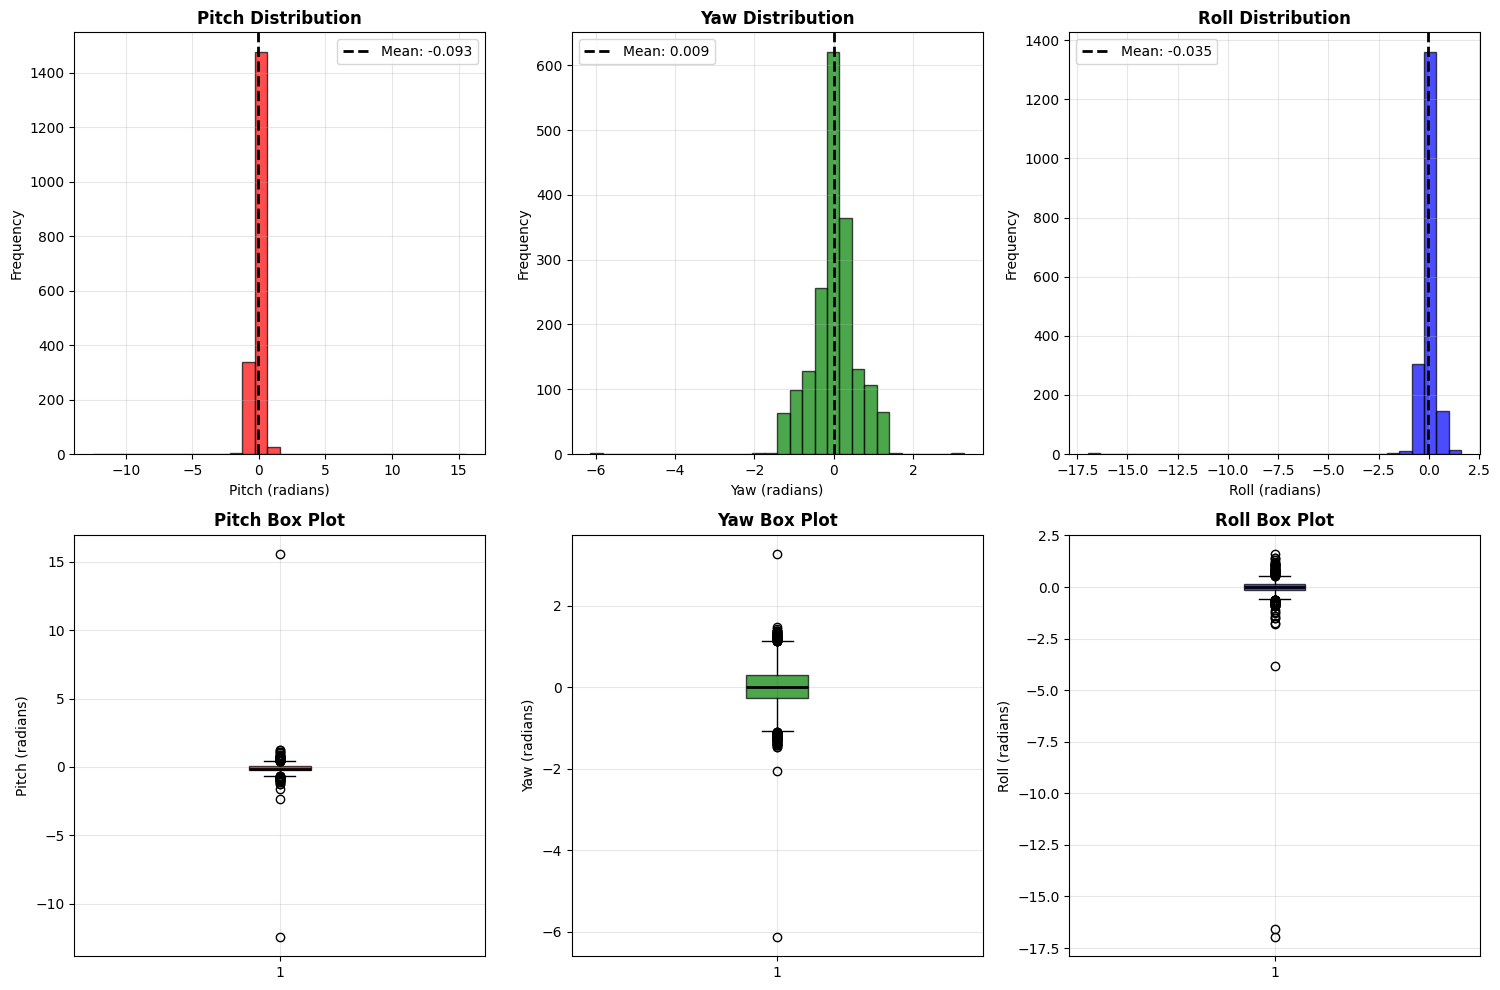

📈 Creating individual distribution plots...


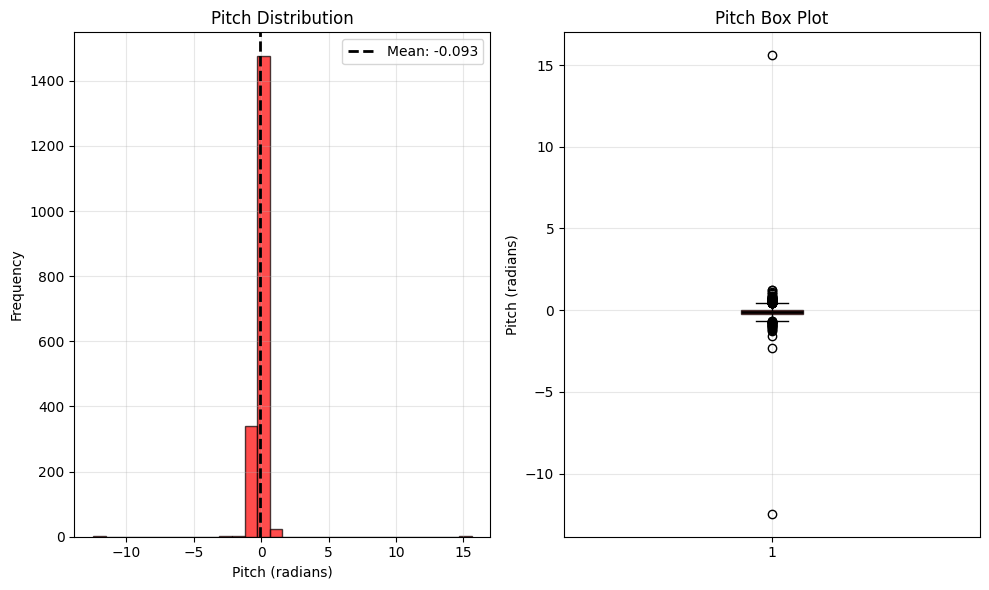


Pitch Statistics:
  Mean: -0.0928
  Std:  0.5403
  Min:  -12.4572
  Max:  15.5988


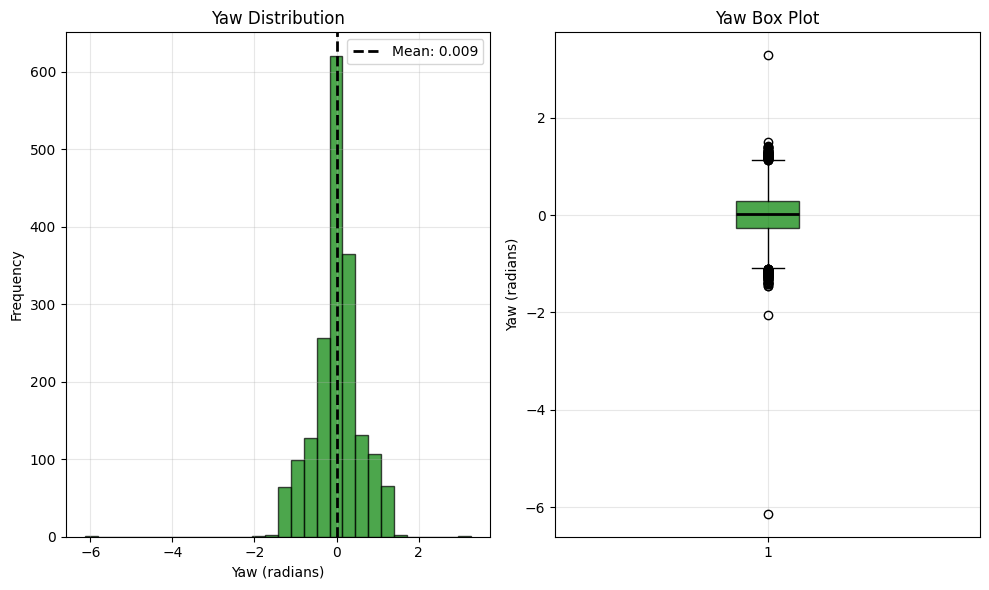


Yaw Statistics:
  Mean: 0.0094
  Std:  0.5725
  Min:  -6.1301
  Max:  3.2775


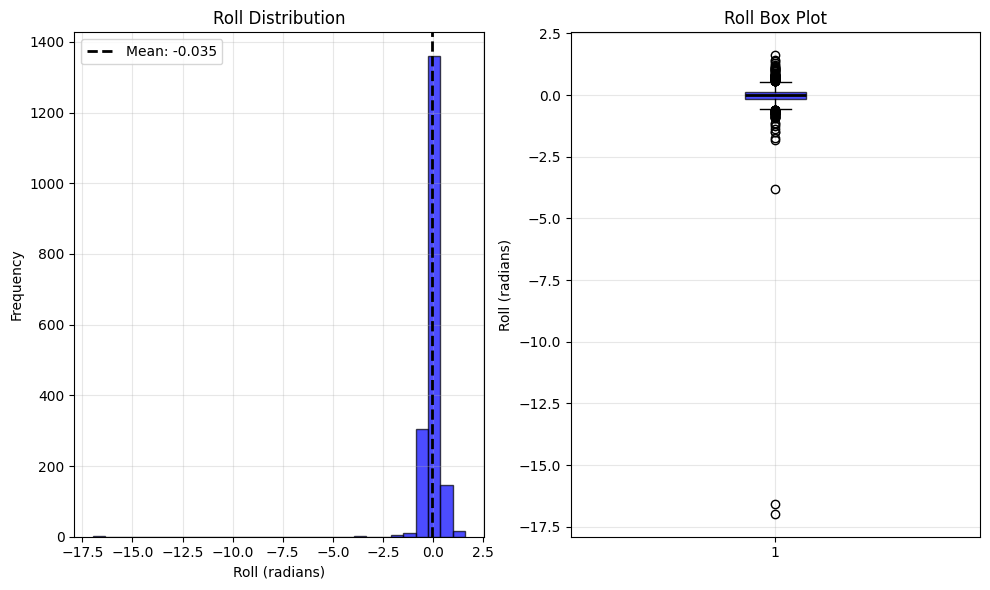


Roll Statistics:
  Mean: -0.0348
  Std:  0.6401
  Min:  -16.9694
  Max:  1.6110


In [37]:
# Visualize distributions
print("📊 Creating pose distribution visualizations...")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Define colors for each angle
colors = ['red', 'green', 'blue']
angles = ['Pitch', 'Yaw', 'Roll']

# Histograms
for i, angle in enumerate(angles):
    axes[0, i].hist(pose_df[angle], bins=30, alpha=0.7, color=colors[i], edgecolor='black')
    axes[0, i].set_title(f'{angle} Distribution', fontsize=12, fontweight='bold')
    axes[0, i].set_xlabel(f'{angle} (radians)', fontsize=10)
    axes[0, i].set_ylabel('Frequency', fontsize=10)
    axes[0, i].grid(True, alpha=0.3)

    # Add statistics text
    mean_val = pose_df[angle].mean()
    std_val = pose_df[angle].std()
    axes[0, i].axvline(mean_val, color='black', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.3f}')
    axes[0, i].legend()

# Box plots
for i, angle in enumerate(angles):
    bp = axes[1, i].boxplot(pose_df[angle], patch_artist=True,
                           boxprops=dict(facecolor=colors[i], alpha=0.7),
                           medianprops=dict(color='black', linewidth=2))
    axes[1, i].set_title(f'{angle} Box Plot', fontsize=12, fontweight='bold')
    axes[1, i].set_ylabel(f'{angle} (radians)', fontsize=10)
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional individual plots for better visibility
print("📈 Creating individual distribution plots...")
for i, angle in enumerate(angles):
    plt.figure(figsize=(10, 6))

    # Create subplot with histogram and box plot side by side
    plt.subplot(1, 2, 1)
    plt.hist(pose_df[angle], bins=30, alpha=0.7, color=colors[i], edgecolor='black')
    plt.title(f'{angle} Distribution')
    plt.xlabel(f'{angle} (radians)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    # Add statistics
    mean_val = pose_df[angle].mean()
    std_val = pose_df[angle].std()
    plt.axvline(mean_val, color='black', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.3f}')
    plt.legend()

    plt.subplot(1, 2, 2)
    bp = plt.boxplot(pose_df[angle], patch_artist=True,
                     boxprops=dict(facecolor=colors[i], alpha=0.7),
                     medianprops=dict(color='black', linewidth=2))
    plt.title(f'{angle} Box Plot')
    plt.ylabel(f'{angle} (radians)')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print statistics for each angle
    print(f"\n{angle} Statistics:")
    print(f"  Mean: {mean_val:.4f}")
    print(f"  Std:  {std_val:.4f}")
    print(f"  Min:  {pose_df[angle].min():.4f}")
    print(f"  Max:  {pose_df[angle].max():.4f}")

In [39]:
# Correlation analysis
print("\n🔗 Pose Angle Correlations:")
correlation_matrix = pose_df.corr()
print(correlation_matrix)


🔗 Pose Angle Correlations:
          Pitch       Yaw      Roll
Pitch  1.000000  0.245373 -0.063853
Yaw    0.245373  1.000000  0.004524
Roll  -0.063853  0.004524  1.000000


📊 Creating correlation heatmap...


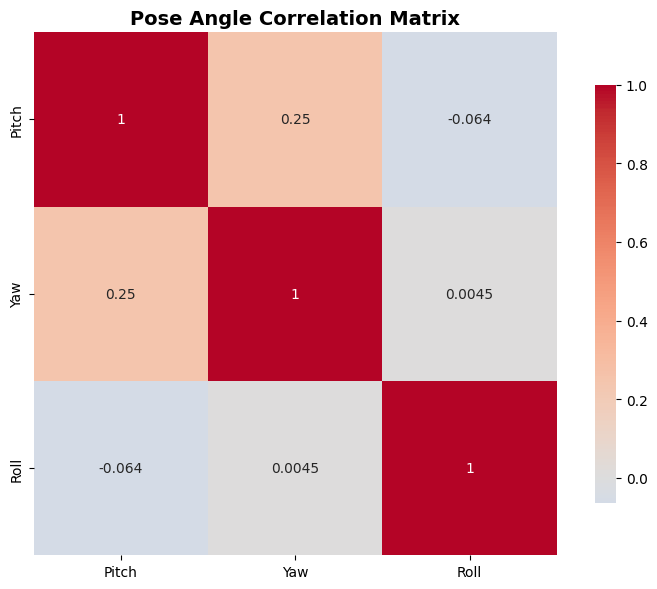

In [40]:
print("📊 Creating correlation heatmap...")
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, cbar_kws={'shrink': 0.8})
plt.title('Pose Angle Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

🔍 Creating scatter plots for angle relationships...


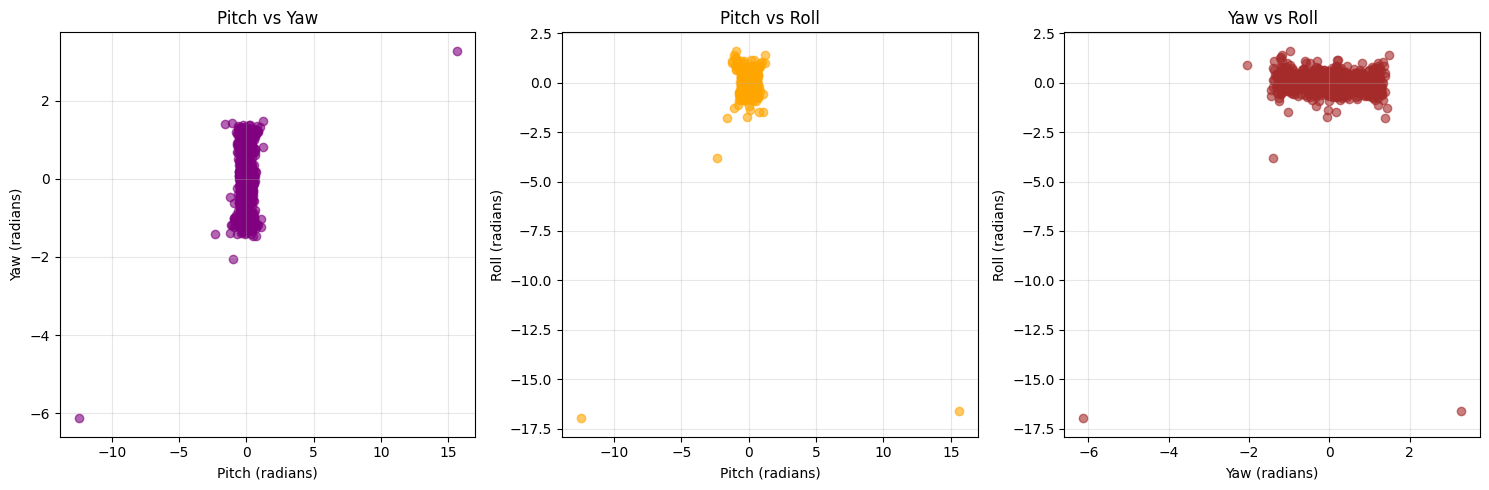

In [41]:
# Create scatter plots to visualize relationships
print("🔍 Creating scatter plots for angle relationships...")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

scatter_pairs = [('Pitch', 'Yaw'), ('Pitch', 'Roll'), ('Yaw', 'Roll')]
colors_scatter = ['purple', 'orange', 'brown']

for i, (x_angle, y_angle) in enumerate(scatter_pairs):
    axes[i].scatter(pose_df[x_angle], pose_df[y_angle], alpha=0.6, color=colors_scatter[i])
    axes[i].set_xlabel(f'{x_angle} (radians)')
    axes[i].set_ylabel(f'{y_angle} (radians)')
    axes[i].set_title(f'{x_angle} vs {y_angle}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. MODELS TRAINING AND EVALUATION

In [42]:
print("\n🤖 Training Machine Learning Models...")

# Define models to train
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'SVR': SVR(kernel='rbf', C=1.0),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42, verbosity=0)
}


🤖 Training Machine Learning Models...


In [43]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
# Store results
results = {'Pitch': {}, 'Yaw': {}, 'Roll': {}}
best_models = {'Pitch': None, 'Yaw': None, 'Roll': None}
best_scores = {'Pitch': -np.inf, 'Yaw': -np.inf, 'Roll': -np.inf}

In [46]:
print("Training models for each pose angle...")

for angle_idx, angle_name in enumerate(['Pitch', 'Yaw', 'Roll']):
    print(f"\n📐 Training models for {angle_name}...")

    y_train_angle = y_train[:, angle_idx]
    y_test_angle = y_test[:, angle_idx]

    for model_name, model in models.items():
        print(f"  Training {model_name}...")

        # Train model
        if model_name in ['SVR']:
            model.fit(X_train_scaled, y_train_angle)
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train_angle)
            y_pred = model.predict(X_test)

        # Evaluate
        mse = mean_squared_error(y_test_angle, y_pred)
        r2 = r2_score(y_test_angle, y_pred)
        mae = mean_absolute_error(y_test_angle, y_pred)

        results[angle_name][model_name] = {
            'MSE': mse,
            'R2': r2,
            'MAE': mae,
            'Model': model
        }

        # Track best model
        if r2 > best_scores[angle_name]:
            best_scores[angle_name] = r2
            best_models[angle_name] = model

        print(f"    {model_name} - R²: {r2:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}")


Training models for each pose angle...

📐 Training models for Pitch...
  Training LinearRegression...
    LinearRegression - R²: -18.0864, MSE: 1.7769, MAE: 0.6160
  Training Ridge...
    Ridge - R²: 0.3260, MSE: 0.0628, MAE: 0.1284
  Training Lasso...
    Lasso - R²: -0.0048, MSE: 0.0935, MAE: 0.2110
  Training ElasticNet...
    ElasticNet - R²: -0.0048, MSE: 0.0935, MAE: 0.2110
  Training DecisionTree...
    DecisionTree - R²: 0.1926, MSE: 0.0752, MAE: 0.1429
  Training SVR...
    SVR - R²: 0.6171, MSE: 0.0356, MAE: 0.0932
  Training RandomForest...
    RandomForest - R²: 0.5779, MSE: 0.0393, MAE: 0.0967
  Training XGBoost...
    XGBoost - R²: 0.6178, MSE: 0.0356, MAE: 0.0978

📐 Training models for Yaw...
  Training LinearRegression...
    LinearRegression - R²: -4.0193, MSE: 1.6712, MAE: 0.5847
  Training Ridge...
    Ridge - R²: 0.8883, MSE: 0.0372, MAE: 0.1092
  Training Lasso...
    Lasso - R²: -0.0013, MSE: 0.3334, MAE: 0.4211
  Training ElasticNet...
    ElasticNet - R²: -0.001

In [47]:
# Display best models
print("\n🏆 Best Models:")
for angle_name in ['Pitch', 'Yaw', 'Roll']:
    best_model_name = None
    for model_name, metrics in results[angle_name].items():
        if metrics['R2'] == best_scores[angle_name]:
            best_model_name = model_name
            break
    print(f"{angle_name}: {best_model_name} (R² = {best_scores[angle_name]:.4f})")


🏆 Best Models:
Pitch: XGBoost (R² = 0.6178)
Yaw: RandomForest (R² = 0.9278)
Roll: RandomForest (R² = 0.5985)


In [48]:
# Get the best models for each component with fallback training
print("\n🔧 Preparing trained best models with fallbacks...")
trained_best_models = {
    'Yaw': best_models.get('Yaw', RandomForestRegressor(random_state=42).fit(X_train_scaled, y_train[:, 1])), # Fallback if not found
    'Pitch': best_models.get('Pitch', RandomForestRegressor(random_state=42).fit(X_train_scaled, y_train[:, 0])), # Fallback
    'Roll': best_models.get('Roll', RandomForestRegressor(random_state=42).fit(X_train_scaled, y_train[:, 2]))   # Fallback
}


🔧 Preparing trained best models with fallbacks...


In [49]:
print("✅ Trained best models ready:")
for angle, model in trained_best_models.items():
    print(f"  {angle}: {type(model).__name__}")

✅ Trained best models ready:
  Yaw: RandomForestRegressor
  Pitch: XGBRegressor
  Roll: RandomForestRegressor


In [50]:
# Create results comparison table
results_df = []
for angle in ['Pitch', 'Yaw', 'Roll']:
    for model_name, metrics in results[angle].items():
        results_df.append({
            'Angle': angle,
            'Model': model_name,
            'R2': metrics['R2'],
            'MSE': metrics['MSE'],
            'MAE': metrics['MAE']
        })

In [51]:
results_df = pd.DataFrame(results_df)
print("\n📊 Complete Results Summary:")
print(results_df.pivot(index='Model', columns='Angle', values='R2').round(4))


📊 Complete Results Summary:
Angle               Pitch    Roll     Yaw
Model                                    
DecisionTree       0.1926  0.4093  0.8049
ElasticNet        -0.0048 -0.0066 -0.0013
Lasso             -0.0048 -0.0066 -0.0013
LinearRegression -18.0864 -2.4429 -4.0193
RandomForest       0.5779  0.5985  0.9278
Ridge              0.3260 -1.3675  0.8883
SVR                0.6171  0.5564  0.9094
XGBoost            0.6178  0.0346  0.9018


# 5. PREDICTION FUNCTIONS

In [52]:
def predict_pose_from_image(image_path, scaler, trained_models):
    """Predict pose angles from a single image"""
    landmarks = extract_landmarks(image_path)
    if landmarks is None:
        return None, None, None

    # Reshape for prediction
    landmarks = landmarks.reshape(1, -1)
    landmarks_scaled = scaler.transform(landmarks)

    # Use trained best models (all use scaled data for consistency)
    pitch_pred = trained_models['Pitch'].predict(landmarks_scaled)[0]
    yaw_pred = trained_models['Yaw'].predict(landmarks_scaled)[0]
    roll_pred = trained_models['Roll'].predict(landmarks_scaled)[0]

    return pitch_pred, yaw_pred, roll_pred

# 6. TESTING

In [69]:
def draw_axis_function(img, pitch, yaw, roll, tdx=None, tdy=None, size=100):
    """Draw 3D coordinate axes on image, originating from the nose."""
    yaw = -yaw
    # The origin (tdx, tdy) is where the axes are drawn.
    # We will calculate this based on the nose landmark.

    if tdx is None or tdy is None:
        # If tdx or tdy are not provided, we need to get the nose landmark
        # This requires running face_mesh detection again, which is not ideal
        # but necessary if the origin isn't explicitly passed based on landmarks.
        # A better approach would be to pass the nose landmark coordinates directly
        # from where draw_axis is called (e.g., visualize_sample_with_landmarks or test_on_single_image).
        # For this modification, we'll assume the caller *should* provide tdx, tdy
        # based on a detected landmark, but include a fallback.

        print("Warning: Nose coordinates (tdx, tdy) not provided to draw_axis. Attempting face detection...")
        results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks:
            # Assuming the nose tip is landmark index 4 (based on some common landmark sets,
            # but MediaPipe's index for the nose *tip* isn't consistently 4.
            # A more reliable index for the bottom center of the nose is often 1 or 6.
            # Let's use index 1, which is near the bottom center of the nose bridge.
            nose_landmark = results.multi_face_landmarks[0].landmark[1]
            h, w, _ = img.shape
            tdx = int(nose_landmark.x * w)
            tdy = int(nose_landmark.y * h)
            print(f"Calculated nose coordinates: ({tdx}, {tdy})")
        else:
            print("Error: Face not detected in fallback mode. Drawing axes at image center.")
            height, width = img.shape[:2]
            tdx = width / 2
            tdy = height / 2
    else:
        # Use the provided nose coordinates
        tdx = int(tdx)
        tdy = int(tdy)

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (tdx, tdy), (int(x1), int(y1)), (0, 0, 255), 3)
    cv2.line(img, (tdx, tdy), (int(x2), int(y2)), (0, 255, 0), 3)
    cv2.line(img, (tdx, tdy), (int(x3), int(y3)), (255, 0, 0), 2)
    return img

# def visualize_sample_with_landmarks_function(sample_idx=0):
#     """Visualize a sample image with landmarks and pose axes"""
#     base_name = valid_files[sample_idx]
#     image_path = os.path.join(DATASET_PATH, base_name + '.jpg')
#     image = cv2.imread(image_path)

#     # Check if image loaded successfully
#     if image is None:
#         print(f"Error: Could not load image {base_name}.jpg")
#         return

#     # Use MediaPipe to find landmarks again to get nose coordinates
#     results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#     nose_tdx, nose_tdy = None, None

#     if results and results.multi_face_landmarks:
#         face_landmarks = results.multi_face_landmarks[0]
#         h, w, _ = image.shape

#         # Draw all landmarks (optional, already in original)
#         # for landmark in face_landmarks.landmark:
#         #     x = int(landmark.x * w)
#         #     y_coord = int(landmark.y * h)
#         #     if 0 <= x < w and 0 <= y_coord < h:
#         #          cv2.circle(image, (x, y_coord), 1, (0, 255, 0), 1)

#         # Get nose landmark coordinates (using index 1 as a potential nose point)
#         # Adjust index if needed based on MediaPipe's specific mapping for the nose tip/bridge.
#         nose_landmark = face_landmarks.landmark[1]
#         nose_tdx = int(nose_landmark.x * w)
#         nose_tdy = int(nose_landmark.y * h)


#     # Draw pose axes starting from the nose coordinates
#     if isinstance(y, np.ndarray) and y.shape[0] > sample_idx:
#         pitch, yaw, roll = y[sample_idx]
#         # Pass the calculated nose coordinates to draw_axis
#         image_with_axes = draw_axis_function(image.copy(), pitch, yaw, roll, tdx=nose_tdx, tdy=nose_tdy)
#     else:
#         print(f"Error: 'y' is not in the expected format or sample_idx {sample_idx} is out of bounds.")
#         image_with_axes = image.copy() # Just show original image if pose data is problematic


#     print(f"Sample {sample_idx}: Pitch={pitch:.2f}, Yaw={yaw:.2f}, Roll={roll:.2f}")
#     # cv2_imshow(image) # Optional: show image with just landmarks
#     cv2_imshow(image_with_axes)


In [70]:
def test_on_single_image(image_path):
    """Test pose prediction on a single image and draw axes on the nose."""
    print(f"\n🖼️ Testing on image: {image_path}")

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print("❌ Could not load image")
        return

    # Predict pose
    # This function already uses the trained models
    pitch_pred, yaw_pred, roll_pred = predict_pose_from_image(image_path, scaler, trained_best_models)

    if pitch_pred is None:
        print("❌ Could not detect face in image or predict pose.")
        return

    print(f"Predicted Pose - Pitch: {pitch_pred:.3f}, Yaw: {yaw_pred:.3f}, Roll: {roll_pred:.3f}")

    # To draw axes on the nose, we need the nose coordinates.
    # We can re-run face_mesh detection on the image.
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    nose_tdx, nose_tdy = None, None

    if results and results.multi_face_landmarks:
        face_landmarks = results.multi_face_landmarks[0]
        h, w, _ = image.shape
        # Use landmark index 1 for the nose origin
        nose_landmark = face_landmarks.landmark[1]
        nose_tdx = int(nose_landmark.x * w)
        nose_tdy = int(nose_landmark.y * h)
    else:
        print("Warning: Face not detected again for nose point. Drawing axes at image center.")
        h, w, _ = image.shape
        nose_tdx = w // 2
        nose_tdy = h // 2

    # Visualize result, passing the nose coordinates
    result_image = draw_axis_function(image.copy(), pitch_pred, yaw_pred, roll_pred, tdx=nose_tdx, tdy=nose_tdy)
    cv2_imshow(result_image)


🖼️ Testing on image: /content/B.jpg
Predicted Pose - Pitch: -0.216, Yaw: -0.222, Roll: -0.222


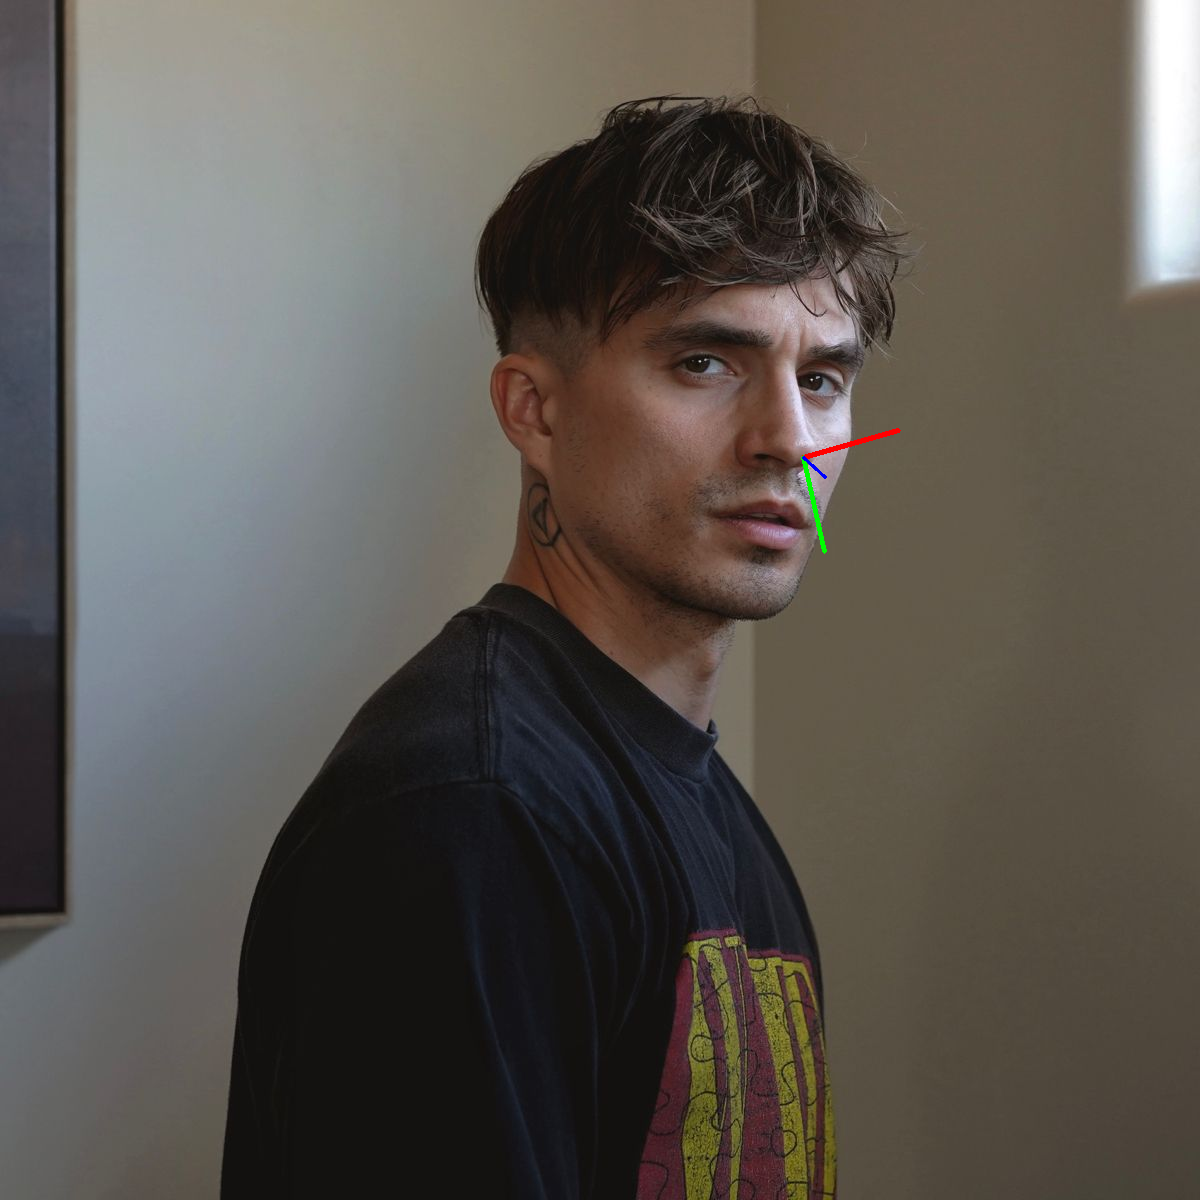

In [71]:
test_on_single_image('/content/B.jpg')


🖼️ Testing on image: /content/ A.jpg
Predicted Pose - Pitch: -0.004, Yaw: 0.001, Roll: 0.001


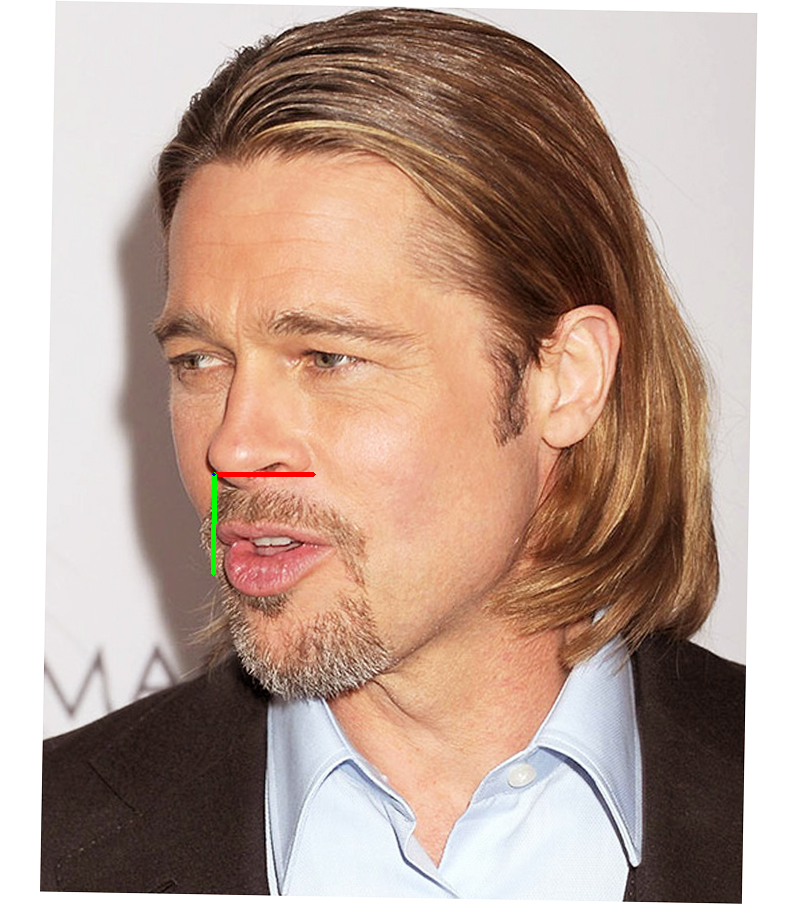

In [72]:
test_on_single_image('/content/ A.jpg')


🖼️ Testing on image: /content/R.jpg
Predicted Pose - Pitch: -0.033, Yaw: 0.012, Roll: 0.012


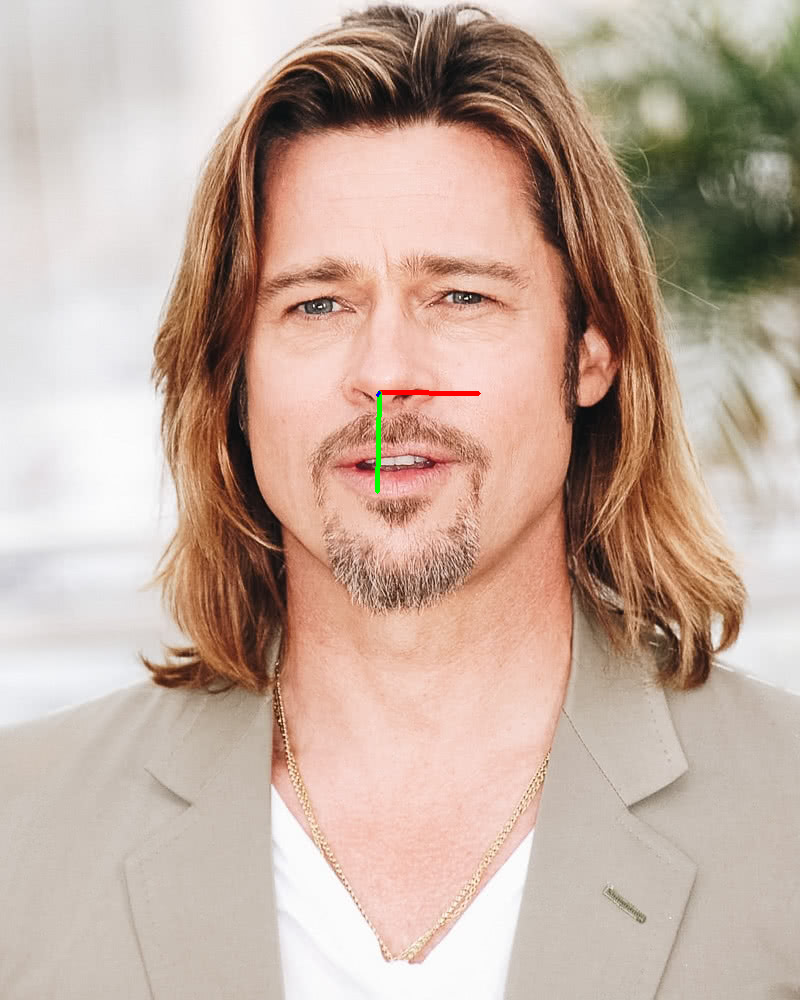

In [73]:
test_on_single_image('/content/R.jpg')

In [74]:
def test_on_video(video_path, output_path=None):
    """Test pose prediction on video"""
    print(f"\n🎥 Testing on video: {video_path}")

    cap = cv2.VideoCapture(video_path)

    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Save frame temporarily
        temp_path = '/tmp/temp_frame.jpg'
        cv2.imwrite(temp_path, frame)

        # Predict pose
        pitch_pred, yaw_pred, roll_pred = predict_pose_from_image(temp_path, scaler, trained_best_models)

        if pitch_pred is not None:
            frame = draw_axis_function(frame, pitch_pred, yaw_pred, roll_pred)
            # Add text overlay
            cv2.putText(frame, f'P:{pitch_pred:.2f} Y:{yaw_pred:.2f} R:{roll_pred:.2f}',
                       (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        if output_path:
            out.write(frame)

        frame_count += 1
        if frame_count % 30 == 0:
            print(f"Processed {frame_count} frames")

    cap.release()
    if output_path:
        out.release()
        print(f"✅ Video saved to {output_path}")

In [75]:
test_on_video('/content/Video.mov')


🎥 Testing on video: /content/Video.mov
Calculated nose coordinates: (1100, 313)
Calculated nose coordinates: (1100, 315)
Calculated nose coordinates: (1100, 315)
Calculated nose coordinates: (1100, 315)
Calculated nose coordinates: (1099, 315)
Calculated nose coordinates: (1099, 314)
Calculated nose coordinates: (1098, 313)
Calculated nose coordinates: (1099, 313)
Calculated nose coordinates: (1098, 312)
Calculated nose coordinates: (1098, 311)
Calculated nose coordinates: (1098, 311)
Calculated nose coordinates: (1098, 312)
Calculated nose coordinates: (1098, 312)
Calculated nose coordinates: (1099, 312)
Calculated nose coordinates: (1100, 312)
Calculated nose coordinates: (1100, 312)
Calculated nose coordinates: (1100, 312)
Calculated nose coordinates: (1100, 313)
Calculated nose coordinates: (1100, 313)
Calculated nose coordinates: (1100, 313)
Calculated nose coordinates: (1100, 313)
Calculated nose coordinates: (1100, 311)
Calculated nose coordinates: (1100, 311)
Calculated nose c

In [76]:
test_on_video('/content/Video.mov', output_path='/content/output_video.mp4')


🎥 Testing on video: /content/Video.mov
Calculated nose coordinates: (1100, 313)
Calculated nose coordinates: (1100, 315)
Calculated nose coordinates: (1100, 315)
Calculated nose coordinates: (1100, 315)
Calculated nose coordinates: (1099, 315)
Calculated nose coordinates: (1099, 314)
Calculated nose coordinates: (1098, 313)
Calculated nose coordinates: (1099, 313)
Calculated nose coordinates: (1098, 312)
Calculated nose coordinates: (1098, 311)
Calculated nose coordinates: (1098, 311)
Calculated nose coordinates: (1098, 312)
Calculated nose coordinates: (1098, 312)
Calculated nose coordinates: (1099, 312)
Calculated nose coordinates: (1100, 312)
Calculated nose coordinates: (1100, 312)
Calculated nose coordinates: (1100, 312)
Calculated nose coordinates: (1100, 313)
Calculated nose coordinates: (1100, 313)
Calculated nose coordinates: (1100, 313)
Calculated nose coordinates: (1100, 313)
Calculated nose coordinates: (1100, 311)
Calculated nose coordinates: (1100, 311)
Calculated nose c

In [90]:
# # JavaScript to stream webcam video and send frames to Python
# def video_stream():
#   js = Javascript('''
#     var video;
#     var div = document.createElement('div');
#     document.body.appendChild(div);

#     var setup = async () => {
#       video = document.createElement('video');
#       video.style.display = 'none';
#       div.appendChild(video);

#       const stream = await navigator.mediaDevices.getUserMedia({video: true});
#       video.srcObject = stream;
#       await video.play();

#       // Resize the output to fit the video
#       google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
#     };

#     setup();

#     var interval = setInterval(() => {
#       var canvas = document.createElement('canvas');
#       canvas.width = video.videoWidth;
#       canvas.height = video.videoHeight;
#       var ctx = canvas.getContext('2d');
#       ctx.drawImage(video, 0, 0);
#       var dataUrl = canvas.toDataURL('image/jpeg', 0.5);
#       google.colab.output.jupyter.kernel.invoke('notebook_frame', [dataUrl]);
#     }, 100); // Send frame every 100ms

#     google.colab.kernel.comm.register_target('stop_webcam', (comm, msg) => {
#       clearInterval(interval);
#       const stream = video.srcObject;
#       const tracks = stream.getTracks();
#       tracks.forEach(track => track.stop());
#       video.srcObject = null;
#       document.body.removeChild(div);
#     });
#   ''')
#   display(js)

# # Function to decode a base64 image from JavaScript
# def js_to_image(js_reply):
#   """
#   Helper function to decode a base64 image from JavaScript
#   """
#   image_bytes = b64decode(js_reply.split(',')[1])
#   jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
#   img = cv2.imdecode(jpg_as_np, flags=1)
#   return img

# # Global variable to hold the current frame from the webcam
# notebook_frame = None

# # Callback function to receive frames from JavaScript
# def _recv_frame(data_url):
#     global notebook_frame
#     notebook_frame = js_to_image(data_url)

# # Register the callback
# # Add a small delay to allow the Colab JavaScript environment to initialize
# # Add a small delay to allow the Colab JavaScript environment to initialize
# time.sleep(1) # Adding a 1-second delay
# try:
#     # Attempt to open the communication channel
#     eval_js('google.colab.output.jupyter.kernel.comm.open("notebook_frame", {});')
#     # Register the callback function to handle incoming messages
#     get_ipython().kernel.comm_manager.register_target('notebook_frame', _recv_frame)
#     print("Kernel communication registered successfully.")
# except Exception as e:
#     print(f"Error registering kernel communication: {e}")
#     print("Please try running this cell again. If the error persists, restart the Colab runtime.")

# # Function to stop the webcam stream
# def stop_webcam():
#   js = Javascript('''
#     google.colab.kernel.comm.open('stop_webcam', {});
#   ''')
#   display(js)

# # Using the Colab webcam setup
# def test_on_webcam_colab():
#     """Test pose prediction on Colab webcam feed"""
#     print("\n📹 Starting Colab webcam test (press 'q' in the preview window to quit)")

#     # Start the JavaScript video stream
#     video_stream()
#     time.sleep(2) # Give time for the video stream to initialize

#     # We will process frames received via the global variable `notebook_frame`
#     # and display them using cv2_imshow.

#     print("Displaying webcam feed. Press 'q' in the output preview to stop.")

#     last_display_time = time.time()

#     try:
#         while True:
#             # Get the latest frame from the global variable
#             frame = notebook_frame

#             if frame is None:
#                 time.sleep(0.05) # Wait a bit if no frame is available yet
#                 continue

#             # Process the frame (your existing logic)
#             # Convert frame to RGB for mediapipe (if needed, though extract_landmarks handles this)
#             # You might want to save the frame to a temporary file or process it directly if extract_landmarks allows numpy array input
#             # For now, let's use the temporary file approach
#             temp_path = '/tmp/temp_frame.jpg'
#             cv2.imwrite(temp_path, frame)

#             # Predict pose
#             pitch_pred, yaw_pred, roll_pred = predict_pose_from_image(temp_path, scaler, trained_best_models)

#             if pitch_pred is not None:
#                  # Re-run face_mesh on the current frame to get the nose coordinates for drawing axes
#                  results = face_mesh.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
#                  nose_tdx, nose_tdy = None, None

#                  if results and results.multi_face_landmarks:
#                     face_landmarks = results.multi_face_landmarks[0]
#                     h, w, _ = frame.shape
#                     # Use landmark index 1 for the nose origin
#                     nose_landmark = face_landmarks.landmark[1]
#                     nose_tdx = int(nose_landmark.x * w)
#                     nose_tdy = int(nose_landmark.y * h)
#                  else:
#                     # Fallback to center if face not detected for nose point
#                     h, w, _ = frame.shape
#                     nose_tdx = w // 2
#                     nose_tdy = h // 2


#                  # Draw axes on the frame using the nose coordinates
#                  frame = draw_axis_function(frame.copy(), pitch_pred, yaw_pred, roll_pred, tdx=nose_tdx, tdy=nose_tdy) # Use draw_axis_function
#                  # Add text overlay
#                  cv2.putText(frame, f'Pitch: {pitch_pred:.2f}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
#                  cv2.putText(frame, f'Yaw: {yaw_pred:.2f}', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
#                  cv2.putText(frame, f'Roll: {roll_pred:.2f}', (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
#             else:
#                  # Optionally display a message if no face was detected
#                  cv2.putText(frame, 'No face detected', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)


#             # Display the frame using cv2_imshow
#             # To avoid displaying too fast, only display every ~30ms (30fps)
#             current_time = time.time()
#             if (current_time - last_display_time) > (1/30.0):
#                cv2_imshow(frame)
#                last_display_time = current_time

#             # Check for 'q' key press (this only works reliably if the user clicks the cv2_imshow window)
#             # A better way in Colab is often to use a button or just stop the cell execution.
#             # We'll include the waitKey but note its limitations in Colab.
#             # The JavaScript part doesn't handle key presses back to Python easily for stopping.
#             # You typically stop the cell execution manually.
#             if cv2.waitKey(1) & 0xFF == ord('q'):
#                 print("Stopping webcam...")
#                 break

#     except Exception as e:
#         print(f"An error occurred: {e}")
#     finally:
#         # Stop the JavaScript stream when done
#         stop_webcam()
#         cv2.destroyAllWindows()
#         print("Webcam test finished.")


In [89]:
# Call the new Colab-compatible webcam test function
#test_on_webcam_colab()